In [7]:
import math
import numpy as np
import pandas as pd
%run analysis/uniV3Math.ipynb


In [22]:
# MySwap: https://starkscan.co/contract/0xfff107e2403123c7df78d91728a7ee5cfd557aec0fa2d2bdc5891c286bbfff#read-write-contract-sub-write

# P is Y/X
def get_il(Pnow, Pstart, Pa, Pb):
    k = Pnow / float(Pstart)
    return (2 * math.sqrt(k) - 1 - k) / (1 + k - math.sqrt(Pa/float(Pstart)) - k * math.sqrt(Pstart / float(Pb)))

# qtys are decimal adjusted. i.e. for 1.01 ETH as x, xQty is 1.01 and not (1.01 * 10**18)
# xPrice is price in USD (float)
def get_hodlings_usd(xQty: float, xPrice: float, yQty: float, yPrice: float):
    return xQty * xPrice + yQty * yPrice

# E.g. Pool STRK/ETH
# X is amount of ETH at a tick in pool
# Y is amount of STRK at a tick in pool
xDecimals = 18
yDecimals = 18
simulationPeriod = 90 # days
expectedYieldPercent = 100 # e.g. 100% percent

Pa = 1500 # 1500 STRK per ETH
Pb = 1700 # 1700 STRK per ETH
P = 1600 # Current price

x = 10**18 # initial ETH investment
y = getYFromX(x, Pa ** 0.5, Pb ** 0.5, P ** 0.5)

Pdiff = Pb - Pa # Pb >= Pa always
# We vary Pnow from [Pa - (Pdiff / 2)] to [Pb + (Pdiff/2)]
step = (Pdiff * 2) / 100 # Divides total chart range in 100 points

yPrice = 2.0 # STRK price USD

i = 0
rows = []
for Pnow in np.arange(Pa - (Pdiff / 2), Pb + (Pdiff/2), step):
    # We fix USD price of one token to get other token usd price
    xPrice = yPrice * (Pnow * (10 ** (xDecimals - yDecimals)))
    hdl = get_hodlings_usd(x / 10.0 ** xDecimals, xPrice, y / 10.0**yDecimals, yPrice)
    il = get_il(Pnow, P, Pa, Pb)
    valueWithIL = hdl * (1 + il)
    expectedYield = hdl * (expectedYieldPercent / 100) * simulationPeriod / 365
    netValue = valueWithIL + expectedYield
    rows.append({
        'price': Pnow,
        'hodl': hdl,
        'ILValue': valueWithIL,
        'netValue': netValue
    })
    
df = pd.DataFrame(rows, columns=['price', 'hodl', 'ILValue', 'netValue'])
df.set_index('price', inplace=True)


Step: 4.0


<Axes: xlabel='price'>

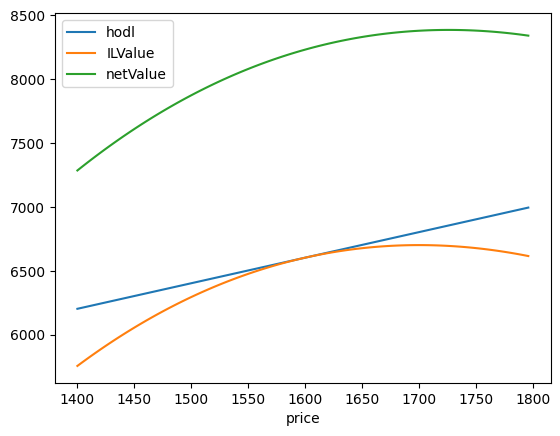

In [23]:
df.plot.line()